In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
#     ldiag = DFlow([NVPFlow(dim=k, name='lowerd_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([LinearChol(dim=dim[0]*dim[1], name='lc', aux_vars=aux_vars)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 20, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
# df = dim[0]*dim[1]*10
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [20]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [21]:
sess = tf.InteractiveSession()

In [22]:
tf.global_variables_initializer().run()

In [23]:
prior.eval(), ent.eval(), logl.eval()

(-11247.4388997289, 704.9857850395491, -4636.036050768138)

In [24]:
loss.eval()

106.69645381162182

In [25]:
np.set_printoptions(precision=4)

In [26]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.0000e+04, -3.2296e+00,  4.7417e+00],
       [-3.2296e+00,  1.0000e+04,  1.0004e+00],
       [ 4.7417e+00,  1.0004e+00,  1.0000e+04]])

In [27]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [ ]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

0.29501340479661925
[[ 2.6539e+03 -2.1232e+00 -3.2345e-01]
 [-2.1232e+00  2.6468e+03  3.1552e+00]
 [-3.2345e-01  3.1552e+00  2.5763e+03]]


0.30455346184586696
[[ 2.6535e+03 -1.9602e+00 -3.1772e-01]
 [-1.9602e+00  2.6345e+03  3.3378e+00]
 [-3.1772e-01  3.3378e+00  2.5820e+03]]


0.2967509384955951
[[ 2.6523e+03 -1.8810e+00 -1.4317e-01]
 [-1.8810e+00  2.6427e+03  3.4672e+00]
 [-1.4317e-01  3.4672e+00  2.5735e+03]]


0.3049480288490102
[[ 2.6518e+03 -1.9044e+00 -1.0315e-01]
 [-1.9044e+00  2.6435e+03  3.3258e+00]
 [-1.0315e-01  3.3258e+00  2.5688e+03]]


0.2953821844515218
[[ 2.6511e+03 -1.9417e+00  2.0682e-02]
 [-1.9417e+00  2.6354e+03  3.3352e+00]
 [ 2.0682e-02  3.3352e+00  2.5838e+03]]


0.299495911035
[[ 2.6394e+03 -2.0920e+00 -1.3913e-01]
 [-2.0920e+00  2.6157e+03  3.3910e+00]
 [-1.3913e-01  3.3910e+00  2.5843e+03]]


0.31812234474626727
[[ 2.6373e+03 -2.1057e+00 -3.5770e-01]
 [-2.1057e+00  2.6210e+03  3.3343e+00]
 [-3.5770e-01  3.3343e+00  2.5859e+03]]


0.30432335411951167
[[ 2.634

0.30172532521604295
[[ 2.5389e+03 -1.0132e+00  4.1415e-01]
 [-1.0132e+00  2.5622e+03  1.8688e+00]
 [ 4.1415e-01  1.8688e+00  2.4570e+03]]


0.3117227204543655
[[ 2.5371e+03 -1.0398e+00  3.9306e-01]
 [-1.0398e+00  2.5556e+03  1.8736e+00]
 [ 3.9306e-01  1.8736e+00  2.4612e+03]]


0.3080299499282309
[[ 2.5300e+03 -8.8298e-01  3.4352e-01]
 [-8.8298e-01  2.5385e+03  1.8564e+00]
 [ 3.4352e-01  1.8564e+00  2.4600e+03]]


0.31104893352094315
[[ 2.5428e+03 -1.1671e+00  3.4103e-01]
 [-1.1671e+00  2.5232e+03  1.8830e+00]
 [ 3.4103e-01  1.8830e+00  2.4547e+03]]


0.2984333290769297
[[ 2.5515e+03 -1.2518e+00  2.3922e-01]
 [-1.2518e+00  2.5395e+03  1.9512e+00]
 [ 2.3922e-01  1.9512e+00  2.4616e+03]]


0.29014900415145256
[[ 2.5496e+03 -1.3066e+00  3.0259e-01]
 [-1.3066e+00  2.5420e+03  2.0501e+00]
 [ 3.0259e-01  2.0501e+00  2.4629e+03]]


0.2996635330022618
[[ 2.5497e+03 -1.3613e+00  3.6014e-01]
 [-1.3613e+00  2.5266e+03  1.9988e+00]
 [ 3.6014e-01  1.9988e+00  2.4673e+03]]


0.2973656553931297
[[ 2.

0.29722253219482864
[[ 2.4399e+03 -1.9285e+00  3.9589e-01]
 [-1.9285e+00  2.4540e+03  1.8777e+00]
 [ 3.9589e-01  1.8777e+00  2.3629e+03]]


0.29780178502859656
[[ 2.4445e+03 -1.9054e+00  3.5458e-01]
 [-1.9054e+00  2.4449e+03  1.8215e+00]
 [ 3.5458e-01  1.8215e+00  2.3839e+03]]


0.30620064836404143
[[ 2.4493e+03 -1.8203e+00  3.9291e-01]
 [-1.8203e+00  2.4444e+03  1.8532e+00]
 [ 3.9291e-01  1.8532e+00  2.3857e+03]]


0.30214417688324624
[[ 2.4269e+03 -1.8204e+00  2.8472e-01]
 [-1.8204e+00  2.4444e+03  1.6414e+00]
 [ 2.8472e-01  1.6414e+00  2.3803e+03]]


0.2991964295625766
[[ 2.4216e+03 -2.0357e+00  4.3908e-01]
 [-2.0357e+00  2.4492e+03  1.6194e+00]
 [ 4.3908e-01  1.6194e+00  2.3794e+03]]


0.30558446477639645
[[ 2.4016e+03 -2.0221e+00  3.5342e-01]
 [-2.0221e+00  2.4535e+03  1.7347e+00]
 [ 3.5342e-01  1.7347e+00  2.3615e+03]]


0.29599078313167365
[[ 2.4088e+03 -1.9927e+00  4.8711e-01]
 [-1.9927e+00  2.4653e+03  1.8079e+00]
 [ 4.8711e-01  1.8079e+00  2.3501e+03]]


0.3082927513789791
[[

0.292146455167219
[[ 2.3486e+03 -1.6079e+00 -1.1139e+00]
 [-1.6079e+00  2.3886e+03  1.2817e+00]
 [-1.1139e+00  1.2817e+00  2.2629e+03]]


0.3056170316879123
[[ 2.3311e+03 -1.6041e+00 -1.2640e+00]
 [-1.6041e+00  2.3920e+03  1.2908e+00]
 [-1.2640e+00  1.2908e+00  2.2754e+03]]


0.2917013114130687
[[ 2.3416e+03 -1.5669e+00 -1.1049e+00]
 [-1.5669e+00  2.3763e+03  1.1977e+00]
 [-1.1049e+00  1.1977e+00  2.2816e+03]]


0.291222743147677
[[ 2.3335e+03 -1.5131e+00 -1.1148e+00]
 [-1.5131e+00  2.3746e+03  1.1223e+00]
 [-1.1148e+00  1.1223e+00  2.2818e+03]]


0.29710337380677504
[[ 2.3359e+03 -1.4394e+00 -1.1363e+00]
 [-1.4394e+00  2.3754e+03  1.1138e+00]
 [-1.1363e+00  1.1138e+00  2.2735e+03]]


0.2904728873580041
[[ 2.3463e+03 -1.4004e+00 -1.0840e+00]
 [-1.4004e+00  2.3694e+03  1.1913e+00]
 [-1.0840e+00  1.1913e+00  2.2671e+03]]


0.2937896414530542
[[ 2.3411e+03 -1.4663e+00 -1.0821e+00]
 [-1.4663e+00  2.3558e+03  1.3460e+00]
 [-1.0821e+00  1.3460e+00  2.2578e+03]]


0.3137578643517919
[[ 2.3349

0.27933720839861753
[[ 2.2421e+03 -1.9372e+00 -9.0177e-01]
 [-1.9372e+00  2.2733e+03  1.6360e+00]
 [-9.0177e-01  1.6360e+00  2.1936e+03]]


0.3007528212671626
[[ 2.2386e+03 -2.0176e+00 -1.0049e+00]
 [-2.0176e+00  2.2750e+03  1.5309e+00]
 [-1.0049e+00  1.5309e+00  2.1860e+03]]


0.30424414113521436
[[ 2.2356e+03 -2.0924e+00 -1.0303e+00]
 [-2.0924e+00  2.2660e+03  1.4809e+00]
 [-1.0303e+00  1.4809e+00  2.1844e+03]]


0.2997591782622441
[[ 2.2411e+03 -2.0279e+00 -9.7066e-01]
 [-2.0279e+00  2.2705e+03  1.4881e+00]
 [-9.7066e-01  1.4881e+00  2.1922e+03]]


0.304392197038014
[[ 2.2408e+03 -2.1416e+00 -8.6537e-01]
 [-2.1416e+00  2.2532e+03  1.4436e+00]
 [-8.6537e-01  1.4436e+00  2.1981e+03]]


0.29530585566296047
[[ 2.2274e+03 -2.1257e+00 -9.4179e-01]
 [-2.1257e+00  2.2421e+03  1.3983e+00]
 [-9.4179e-01  1.3983e+00  2.1997e+03]]


0.30910255850517765
[[ 2.2262e+03 -2.1249e+00 -8.8800e-01]
 [-2.1249e+00  2.2509e+03  1.5161e+00]
 [-8.8800e-01  1.5161e+00  2.1785e+03]]


0.2918642433250336
[[ 2.

0.2935208768846254
[[ 2.1704e+03 -1.4242e+00 -3.1112e-01]
 [-1.4242e+00  2.2078e+03  1.6681e+00]
 [-3.1112e-01  1.6681e+00  2.0859e+03]]


0.30237712094554775
[[ 2.1629e+03 -1.4366e+00 -3.8989e-01]
 [-1.4366e+00  2.2078e+03  1.7581e+00]
 [-3.8989e-01  1.7581e+00  2.0837e+03]]


0.28002907802707616
[[ 2.1631e+03 -1.3928e+00 -3.0047e-01]
 [-1.3928e+00  2.1949e+03  1.8784e+00]
 [-3.0047e-01  1.8784e+00  2.0859e+03]]


0.2856271809938721
[[ 2.1674e+03 -1.4278e+00 -2.7178e-01]
 [-1.4278e+00  2.1915e+03  1.8752e+00]
 [-2.7178e-01  1.8752e+00  2.0820e+03]]


0.2929148943740818
[[ 2.1719e+03 -1.2719e+00 -2.6638e-01]
 [-1.2719e+00  2.2058e+03  1.9582e+00]
 [-2.6638e-01  1.9582e+00  2.0959e+03]]


0.30295181380769215
[[ 2.1609e+03 -1.2379e+00 -1.4909e-01]
 [-1.2379e+00  2.2062e+03  2.0855e+00]
 [-1.4909e-01  2.0855e+00  2.1014e+03]]


0.28992451167560723
[[ 2.1597e+03 -1.1135e+00 -9.4698e-02]
 [-1.1135e+00  2.1913e+03  2.0003e+00]
 [-9.4698e-02  2.0003e+00  2.0966e+03]]


0.29449844916933116
[[ 

0.2816724429789173
[[ 2.0840e+03 -1.5151e+00 -4.6789e-01]
 [-1.5151e+00  2.1245e+03  1.6662e+00]
 [-4.6789e-01  1.6662e+00  1.9993e+03]]


0.2951467596237383
[[ 2.0864e+03 -1.4996e+00 -3.6845e-01]
 [-1.4996e+00  2.1216e+03  1.6722e+00]
 [-3.6845e-01  1.6722e+00  2.0060e+03]]


0.30276210165293166
[[ 2.0795e+03 -1.6079e+00 -3.8782e-01]
 [-1.6079e+00  2.1212e+03  1.7568e+00]
 [-3.8782e-01  1.7568e+00  2.0023e+03]]


0.28435543016405707
[[ 2.0882e+03 -1.5563e+00 -4.8768e-01]
 [-1.5563e+00  2.1110e+03  1.7882e+00]
 [-4.8768e-01  1.7882e+00  2.0029e+03]]


0.3071775535314728
[[ 2.0917e+03 -1.5779e+00 -4.9966e-01]
 [-1.5779e+00  2.0993e+03  1.7201e+00]
 [-4.9966e-01  1.7201e+00  2.0053e+03]]


0.29912459470784636
[[ 2.0941e+03 -1.6779e+00 -4.5445e-01]
 [-1.6779e+00  2.1026e+03  1.6766e+00]
 [-4.5445e-01  1.6766e+00  1.9960e+03]]


0.3031903502534727
[[ 2.0942e+03 -1.6602e+00 -4.1024e-01]
 [-1.6602e+00  2.1094e+03  1.7844e+00]
 [-4.1024e-01  1.7844e+00  1.9846e+03]]


0.3036893888762426
[[ 2.

0.284691622487946
[[ 1.9935e+03 -1.2375e+00 -7.6482e-01]
 [-1.2375e+00  2.0431e+03  1.7595e+00]
 [-7.6482e-01  1.7595e+00  1.9633e+03]]


0.28464687323730925
[[ 1.9966e+03 -1.1677e+00 -7.8959e-01]
 [-1.1677e+00  2.0427e+03  1.6533e+00]
 [-7.8959e-01  1.6533e+00  1.9599e+03]]


0.2954235919097094
[[ 2.0026e+03 -1.1977e+00 -8.1041e-01]
 [-1.1977e+00  2.0400e+03  1.7051e+00]
 [-8.1041e-01  1.7051e+00  1.9500e+03]]


0.31336529598673646
[[ 2.0110e+03 -1.2043e+00 -8.1049e-01]
 [-1.2043e+00  2.0416e+03  1.7318e+00]
 [-8.1049e-01  1.7318e+00  1.9555e+03]]


0.29655668030237453
[[ 2.0064e+03 -1.3491e+00 -6.9667e-01]
 [-1.3491e+00  2.0344e+03  1.6502e+00]
 [-6.9667e-01  1.6502e+00  1.9555e+03]]


0.30667296202365385
[[ 2.0046e+03 -1.2669e+00 -8.4139e-01]
 [-1.2669e+00  2.0294e+03  1.5296e+00]
 [-8.4139e-01  1.5296e+00  1.9538e+03]]


0.29608751784192056
[[ 2.0118e+03 -1.3337e+00 -7.3092e-01]
 [-1.3337e+00  2.0339e+03  1.5138e+00]
 [-7.3092e-01  1.5138e+00  1.9489e+03]]


0.28992582231009295
[[ 

In [29]:
# saver = tf.train.Saver()

In [30]:
# saver.save(sess,'/home/nikita/tmp/rdata')

In [31]:
# ss = []
# for _ in range(3000):
#     a = np.linalg.inv(PWalk.inverse_sigma.eval()[:3,:3])
#     ss.append(np.sqrt(np.diag(a)))
# ss = np.array(ss)

In [32]:
# np.mean(ss, axis=0), np.std(ss, axis=0)

In [33]:
a = np.linalg.inv(PWalk.inverse_sigma.eval())
np.sqrt(np.diag(a))

array([0.0193, 0.0194, 0.0197, 0.0195, 0.0187, 0.0187, 0.0189, 0.0194,
       0.0245, 0.0201, 0.0261, 0.0199])

In [34]:
a = np.linalg.inv(PWalk.inverse_sigma.eval())
np.sqrt(np.diag(a))

array([0.0193, 0.0194, 0.0197, 0.0195, 0.0187, 0.0187, 0.0189, 0.0194,
       0.0245, 0.0201, 0.0261, 0.0199])

In [35]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [36]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [37]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [38]:
samples.shape

(3000, 20, 3, 4)

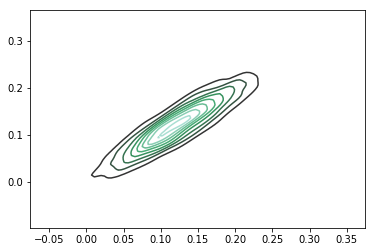

In [39]:
sns.kdeplot(samples[:,10,2,0], samples[:,11,2,0])
plt.show()

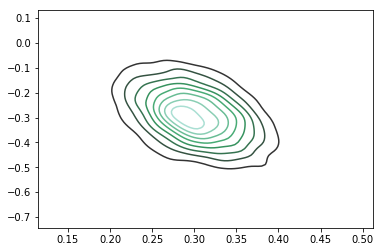

In [301]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

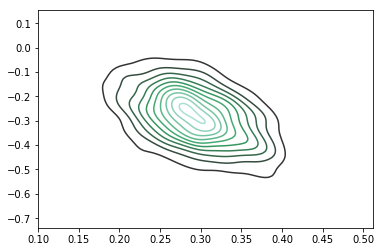

In [286]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [66]:
t = 14
# params[t]

In [67]:
np.mean(samples[:,t], axis=0)

array([[-0.0825,  0.0062, -0.1318, -0.0815],
       [ 0.0564,  0.1373,  0.5275,  0.036 ],
       [ 0.1206, -0.007 ,  0.9351,  0.2774]])

In [64]:
np.std(samples[:,t], axis=0)

array([[0.1049, 0.0981, 0.1117, 0.1097],
       [0.0974, 0.1036, 0.132 , 0.0985],
       [0.0473, 0.0392, 0.052 , 0.1675]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


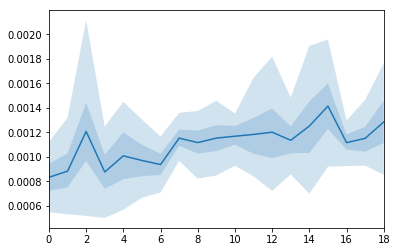

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


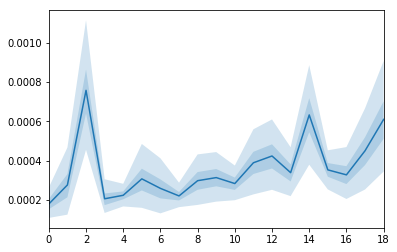

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


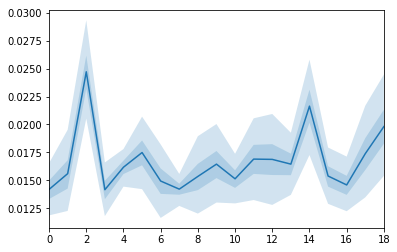

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()